In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import torch
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import datasets
import transformers

In [3]:
torch.cuda.empty_cache()

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [4]:
! cd ./CapstoneProject_Guide-RNA/
! pwd
! ls

/home/minorai7
CapstoneProject_Guide-RNA  models    results1gpu  results3e-4
data			   results1  results2	  Untitled.ipynb


In [5]:
modelpath = "zhihan1996/DNABERT-2-117M"

datapath  = '/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main'

df_train = pd.read_csv(f"{datapath}/sample_data/esp/train_esp_decoded.csv")
df_test = pd.read_csv(f"{datapath}/sample_data/esp/test_esp_decoded.csv")

print(df_train.info())
print(df_train.head())

print(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46893 entries, 0 to 46892
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     46893 non-null  object 
 1   y       46893 non-null  float64
dtypes: float64(1), object(1)
memory usage: 732.8+ KB
None
                     seq         y
0  GCCTGCGAAAAGAGCACGCGC  0.327296
1  GAGGGGGCCGAGTCGATACTC  0.188169
2  GTCTTTGTATCACATCGCAGT  0.274519
3  ACATCCTCCAGGTTTGCCAAA  0.184805
4  GGCCCATTAGTCGAAGGATGA  0.272028
(11724, 2)


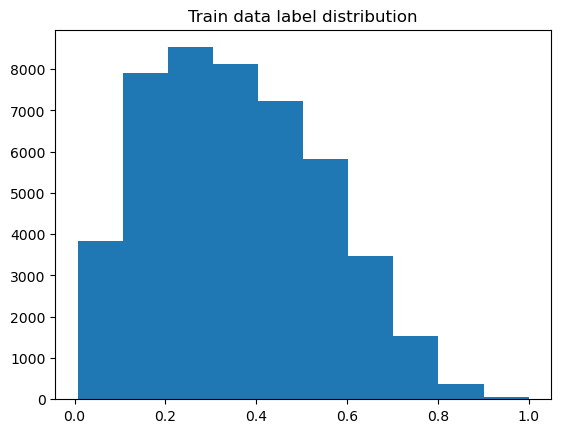

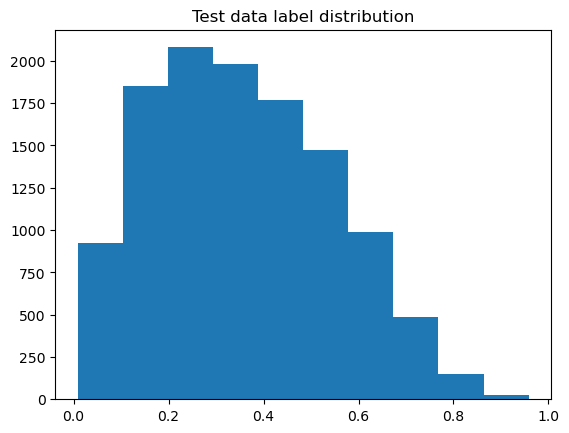

In [6]:
#plot label distribution of test and train data
plt.title("Train data label distribution")
plt.hist(df_train['y'])
plt.show()

plt.title("Test data label distribution")
plt.hist(df_test['y'])
plt.show()

In [7]:
#turn df into a dataset
raw_dataset_train = datasets.Dataset.from_pandas(df_train)
raw_dataset_test = datasets.Dataset.from_pandas(df_test)

print(raw_dataset_train)
print(raw_dataset_test)

Dataset({
    features: ['seq', 'y'],
    num_rows: 46893
})
Dataset({
    features: ['seq', 'y'],
    num_rows: 11724
})


In [8]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [9]:
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset_train = raw_dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_train.set_format("torch")

print(tokenized_dataset_train)

tokenized_dataset_test = raw_dataset_test.map(tokenize_function, batched=True)
tokenized_dataset_test.set_format("torch")

print(tokenized_dataset_test)

Map:   0%|          | 0/46893 [00:00<?, ? examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46893
})


Map:   0%|          | 0/11724 [00:00<?, ? examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11724
})


In [10]:
def clean_tokenized_dataset(dataset):
    dataset = dataset.remove_columns(["seq"])
    dataset = dataset.rename_column("y", "labels")
    dataset.set_format("torch")

    print(dataset.column_names)
    return dataset

tokenized_dataset_train = clean_tokenized_dataset(tokenized_dataset_train)
tokenized_dataset_test = clean_tokenized_dataset(tokenized_dataset_test)

print(tokenized_dataset_train)
print(tokenized_dataset_test)

['labels', 'input_ids', 'token_type_ids', 'attention_mask']
['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46893
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11724
})


In [11]:
print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)

3
100


In [12]:
#from torch.utils.data import DataLoader

#batch_size = 256

# train_dataloader = DataLoader(
#     tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )
#eval_dataloader = DataLoader(
#     tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
#)

In [13]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
    ignore_mismatched_sizes=True
).cuda()

for param in model.base_model.parameters():
    param.requires_grad = False

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
/home/minorai7/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']


In [14]:
# for batch in train_dataloader:
#     print(batch['labels'][0])
#     break
# print({k: v.shape for k, v in batch.items()})

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    logits = logits[0]
    
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [23]:
resultname = "results8_frozen"

# Specifiy the arguments for the trainer  
training_args = transformers.TrainingArguments(
    output_dir =f'{datapath}/{resultname}',
    num_train_epochs = 100,     
    per_device_train_batch_size = 512,   
    per_device_eval_batch_size = 256,   
    weight_decay = 0.01,               
    learning_rate = 3e-5,
    logging_dir = './logs',
    logging_steps = 10,        
    save_total_limit = 3,
    load_best_model_at_end = True,     
    metric_for_best_model = 'mse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

# Call the Trainer
trainer = transformers.Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = tokenized_dataset_train,         
    eval_dataset = tokenized_dataset_test,          
    compute_metrics = compute_metrics,
    data_collator = data_collator, 
)

# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

# Save the model
trainer.save_model(f"{datapath}/models/model8")

Epoch,Training Loss,Validation Loss


TypeError: Cannot interpret '-1' as a data type

In [ ]:
# Call the summary
trainer.evaluate()

{'eval_loss': 0.017807358875870705,
 'eval_mse': 0.017807358875870705,
 'eval_rmse': 0.13344421982765198,
 'eval_mae': 0.10260213911533356,
 'eval_r2': 0.48883802552548605,
 'eval_runtime': 1.7217,
 'eval_samples_per_second': 6809.408,
 'eval_steps_per_second': 26.717,
 'epoch': 100.0}

In [ ]:
df = pd.DataFrame(trainer.state.log_history)


dfstep = df[['step', 'loss', 'learning_rate', 'epoch']].dropna()
dfepoch = df[['epoch', 'eval_loss', 'eval_mse', 'eval_rmse', 'eval_mae', 'eval_r2', 'eval_rho']].dropna()

#create results folder if not exist
if not os.path.exists(f"{datapath}/{resultname}"):
    os.makedirs(f"{datapath}/{resultname}")

#save to file
df.to_csv(f"{datapath}/{resultname}/df.csv")
dfstep.to_csv(f"{datapath}/{resultname}/dfstep.csv")
dfepoch.to_csv(f"{datapath}/{resultname}/dfepoch.csv")
print("saved to file")

saved to file


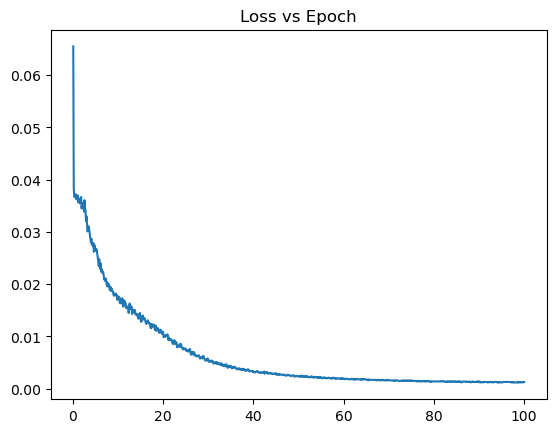

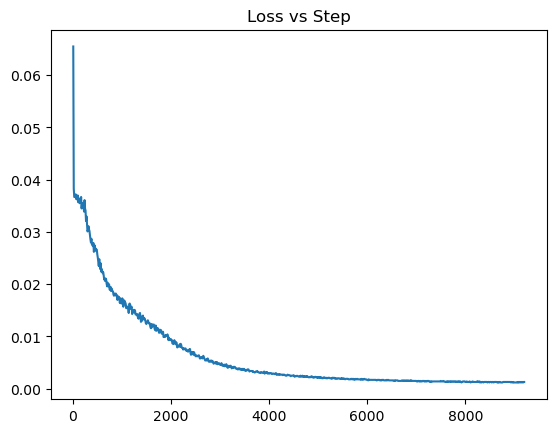

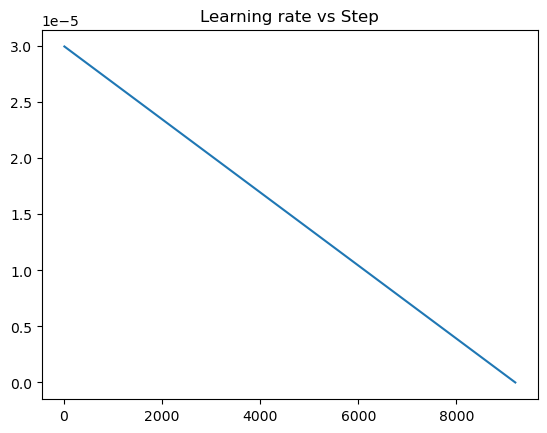

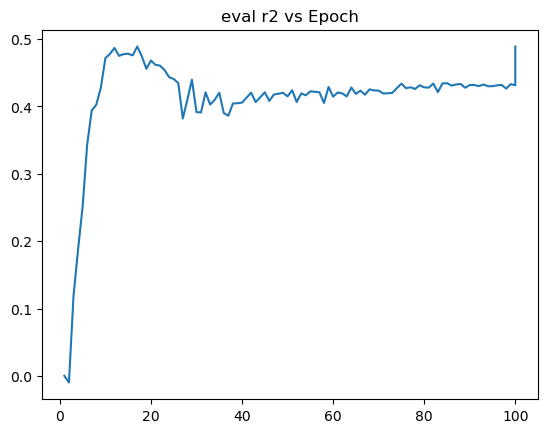

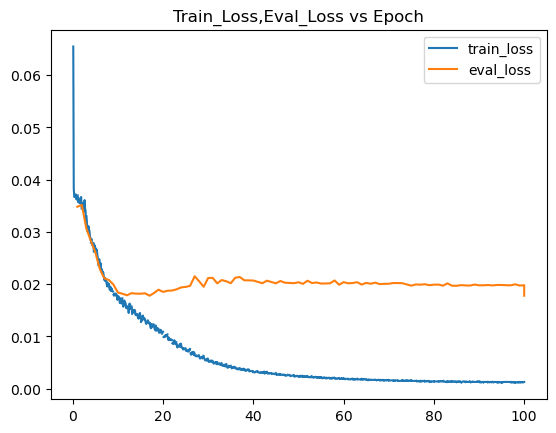

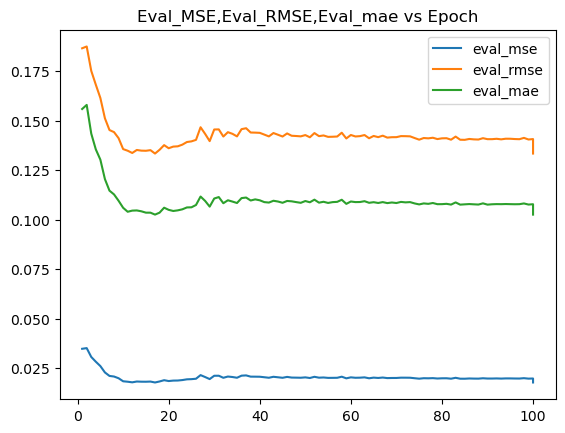

<Figure size 640x480 with 0 Axes>

In [ ]:
#plot loss vs epoch
plt.title("Loss vs Epoch")
plt.plot(dfstep['epoch'], dfstep['loss'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/loss_vs_Epoch.png")
plt.clf()

#plot loss vs step
plt.title("Loss vs Step")
plt.plot(dfstep['step'], dfstep['loss'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/loss_vs_step.png")
plt.clf()

#plot learning rate vs step
plt.title("Learning rate vs Step")
plt.plot(dfstep['step'], dfstep['learning_rate'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/learning_rate_vs_step.png")
plt.clf()

#plot loss vs epoch
plt.title("eval r2 vs Epoch")
plt.plot(dfepoch['epoch'], dfepoch['eval_r2'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/eval_r2_vs_epoch.png")
plt.clf()

#plot eval_loss and loss vs epoch ignore nan from eval_loss
plt.title("Train_Loss,Eval_Loss vs Epoch")
plt.plot(df['epoch'], df['loss'], label='train_loss')
plt.plot(dfepoch['epoch'], dfepoch['eval_loss'], label='eval_loss')
plt.legend()
plt.show()
plt.savefig(f"{datapath}/{resultname}/loss_vs_epoch.png")
plt.clf()


#plot eval_mse and eval_rmse vs epoch
plt.title("Eval_MSE,Eval_RMSE,Eval_mae vs Epoch")
plt.plot(dfepoch['epoch'], dfepoch['eval_mse'], label='eval_mse')
plt.plot(dfepoch['epoch'], dfepoch['eval_rmse'], label='eval_rmse')
plt.plot(dfepoch['epoch'], dfepoch['eval_mae'], label='eval_mae')
plt.legend()
plt.show()
plt.savefig(f"{datapath}/{resultname}/eval_mse_rmse_mae_vs_epoch.png")
plt.clf()


In [ ]:

# from tqdm.auto import tqdm

# model = transformers.AutoModelForSequenceClassification.from_pretrained(
#     "./resultsGPU4r2/checkpoint-4500",
#     cache_dir=None,
#     num_labels=1,
#     trust_remote_code=True,
# )

# model.cuda()

# #metric = evaluate.load("accuracy")
# #model.eval()

# mselist = []
# rmse_list = []
# mae_list = []
# r2_list = []
# difflist = []

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for batch in eval_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}

#     labels = batch["labels"].reshape(-1, 1)

#     with torch.no_grad():
#         outputs = model(**batch)
    
#     #calculate metrics

#     logits = outputs["logits"]
    
#     #print(outputs)

#     #use cpu to calculate metrics
#     logits = logits.cpu()
#     labels = labels.cpu()

#     mse = mean_squared_error(labels, logits)
#     rmse = mean_squared_error(labels, logits, squared=False)
#     mae = mean_absolute_error(labels, logits)
#     r2 = r2_score(labels, logits)
#     #smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

#     diff = (labels[i]-logits[i]).item()
#     #print("mse: ", mse, " rmse: ", rmse, " mae: ", mae, " r2: ", r2)
#     #for i in range(len(labels)):
#         #print("Pred=", logits[i].item(), "    Act=" , labels[i].item(), "    diff=", diff)
    
#     mselist.append(mse)
#     rmse_list.append(rmse)
#     mae_list.append(mae)
#     r2_list.append(r2)
#     difflist.append(diff)

# print("AVG mse: ", np.mean(mselist), " rmse: ", np.mean(rmse_list), " mae: ", np.mean(mae_list), " r2: ", np.mean(r2_list))
# print("Diff mean=",np.mean(difflist),"  max: ", np.max(difflist),"  min: ", np.min(difflist), "  AVG= ", np.sum(np.abs(difflist)) / len(difflist) )
